In [1]:
# scikit-learn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate

import polars as pl
import numpy as np
import optuna
import codecs
import os

In [2]:
# create list of files of the specific directory
def init_lists(folder):
    key_list = []
    file_list = os.listdir(folder)

    for file in file_list:
        f = codecs.open(folder + file, 'r', encoding="utf-8", errors="ignore")
        key_list.append(f.read())
    f.close()

    return key_list

In [3]:
spam = init_lists("../data/enron1/spam/")
ham  = init_lists("../data/enron1/ham/")


spam_data = {"text": spam, "label": np.ones(len(spam))}
spam_df = pl.DataFrame(spam_data)

ham_data = {"text": ham, "label": np.zeros(len(ham))}
ham_df = pl.DataFrame(ham_data)

In [4]:
spam_df.head()

text,label
str,f64
"""Subject: we can date : septem…",1.0
"""Subject: your pharmaceuticals …",1.0
"""Subject: our pro - forma invoi…",1.0
"""Subject: enhance your chest si…",1.0
"""Subject: doing clal 1 is , \ /…",1.0


In [5]:
ham_df.head()

text,label
str,f64
"""Subject: txu nom . for 9 / 27 …",0.0
"""Subject: hpl nom for august 2 …",0.0
"""Subject: re : pg & e texoma vo…",0.0
"""Subject: north central oil cor…",0.0
"""Subject: eastrans nomination c…",0.0


In [6]:
df = pl.concat([
    spam_df,
    ham_df
])

In [7]:
df.head()

text,label
str,f64
"""Subject: we can date : septem…",1.0
"""Subject: your pharmaceuticals …",1.0
"""Subject: our pro - forma invoi…",1.0
"""Subject: enhance your chest si…",1.0
"""Subject: doing clal 1 is , \ /…",1.0


In [8]:
df.tail()

text,label
str,f64
"""Subject: ( see attached file :…",0.0
"""Subject: enron / hpl actuals f…",0.0
"""Subject: hpl nom for april 5 ,…",0.0
"""Subject: deal numbers hi darr…",0.0
"""Subject: october 2000 co - own…",0.0


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize TfidfVectorizer
# stop_words="english" to exclude normal words
tfidf = TfidfVectorizer(stop_words="english")

X = tfidf.fit_transform(df["text"])
column_names = tfidf.get_feature_names_out()

In [10]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 338578 stored elements and shape (5172, 50156)>
  Coords	Values
  (0, 43351)	0.007407901160568591
  (0, 15236)	0.029532988163197743
  (0, 40987)	0.032930065944703074
  (0, 1193)	0.026425996828139994
  (0, 1124)	0.03510621927557778
  (0, 41718)	0.04661874822135729
  (0, 16066)	0.06568162608765238
  (0, 38525)	0.26247855817318505
  (0, 36573)	0.1201874183957498
  (0, 11913)	0.1737102038291315
  (0, 44205)	0.12722959711393012
  (0, 28782)	0.3130799704918586
  (0, 42444)	0.03173063277637518
  (0, 5411)	0.05883184836722746
  (0, 31189)	0.052346462491742
  (0, 6032)	0.05883184836722746
  (0, 30309)	0.046909291387843804
  (0, 11803)	0.04633917160189291
  (0, 36574)	0.05883184836722746
  (0, 44171)	0.05748122829505686
  (0, 20830)	0.04255502587074866
  (0, 40159)	0.030798945586312753
  (0, 19576)	0.06261599409837171
  (0, 16270)	0.11070021587333306
  (0, 21780)	0.05069343711898806
  :	:
  (5171, 34365)	0.09569144407012325
  (5171, 9

In [11]:
X = pl.DataFrame(X.toarray())
X = X.cast(pl.Float32)

In [12]:
X.columns = column_names

In [13]:
y = df["label"].cast(pl.Float32)

In [14]:
y.head()

label
f32
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


## Hyper parameter tuning

In [15]:
# LightGBM
import lightgbm as lgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [16]:
class Objective:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __call__(self, trial):

        param = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }

        # Stratified K-Fold Cross Validation
        k = 5
        skf = StratifiedKFold(n_splits=k)

        score = 0
        for train_idx, test_idx in skf.split(self.X, self.y):
            dtrain = lgb.Dataset(self.X[train_idx], label=self.y[train_idx])
            gbm = lgb.train(param, dtrain)
            preds = gbm.predict(self.X[test_idx])
            pred_labels = np.rint(preds)
            accuracy = accuracy_score(self.y[test_idx], pred_labels)
            score += accuracy
        
        score = score / k # mean value
        
        return score

In [17]:
objective = Objective(X_train, np.array(y_train))
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=60)

[I 2024-10-05 00:49:40,096] A new study created in memory with name: no-name-b68e86a5-55ff-4ca8-9b0f-ee4e45c4f9e9
/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")
/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/lightgbm/basic.p

In [18]:
study.best_params

{'lambda_l1': 0.00021108281193396865,
 'lambda_l2': 4.439672035192966e-08,
 'num_leaves': 63,
 'feature_fraction': 0.9104420157865489,
 'bagging_fraction': 0.9410530615795872,
 'bagging_freq': 6,
 'min_child_samples': 70}

In [19]:
param = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "lambda_l1": study.best_params["lambda_l1"],
    "lambda_l2": study.best_params["lambda_l2"],
    "num_leaves": study.best_params["num_leaves"],
    "feature_fraction": study.best_params["feature_fraction"],
    "bagging_fraction": study.best_params["bagging_fraction"],
    "bagging_freq": study.best_params["bagging_freq"],
    "min_child_samples": study.best_params["min_child_samples"],
}

train_data = lgb.Dataset(X_train, np.array(y_train), feature_name=X_train.columns)

gbm = lgb.train(
    param,
    train_data,
    num_boost_round=100,
)

In [20]:
preds = gbm.predict(X_test)
pred_labels = np.rint(preds)
print("Accuracy: {}".format(accuracy_score(y_test, pred_labels)))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred_labels))

/home/rytst/dev/ml_for_security/venv/lib/python3.12/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


Accuracy: 0.9690821256038648
[[702  18]
 [ 14 301]]


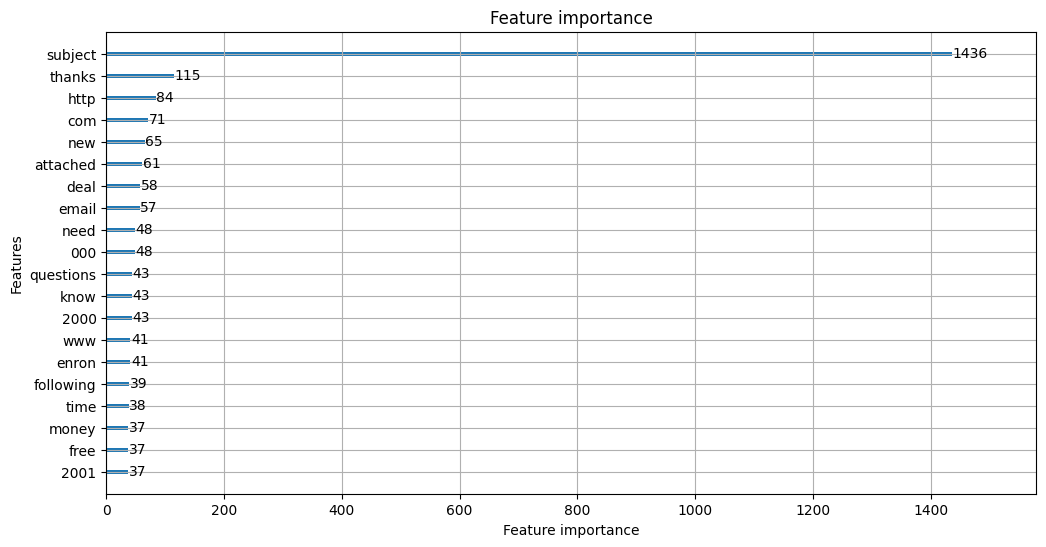

In [21]:
import matplotlib.pyplot as plt

lgb.plot_importance(gbm, figsize=(12, 6), max_num_features=20)
plt.show()

In [22]:
# "subject" word in spam mail

count = 0
for i in spam_data["text"]:
    count = count + i.count("subject")

print(count)

160


In [23]:
# subject word in ham mail

count = 0
for i in ham_df["text"]:
    count = count + i.count("subject")

print(count)

2733
